In [1]:
import numpy as np
import dask , dask.distributed
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import cmocean.cm as cmo
import warnings
warnings.simplefilter('ignore')
import dask_jobqueue
from astropy.convolution import Box2DKernel, convolve
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)
import matplotlib.colors as colors
import pandas as pd
from fix_grid import fix_grid

In this script, the Agulhas region was selected as an exemplary region to show some eddy snapshots and correlations.

# Load Data

In [2]:
pathf='/gxfs_work/geomar/smomw577/mesoscale_eddies/BOX_filtered/0181-0190/'
pathp='/gxfs_home/geomar/smomw577/plots/Boxcar/0181-0190/'

ds_original=xr.open_dataset('/gxfs_work/geomar/smomw577/mesoscale_eddies/MOM5_concat/0181-0190/MOM5_monthly_0181-0190_noice_all.nc')
dsa=xr.open_dataset(pathf+'3x3box_median_anomaly_monthly_0181-0190_all.nc')
ds_smoothed=xr.open_dataset(pathf+'3x3box_median_monthly_0181-0190_noice_all.nc')
ds_corr=xr.open_dataset(pathf+'3x3box_median_corr_monthly_0181-0190_noice_all.nc')
mld_corr=xr.load_dataset(pathf+'3x3box_median_corr_monthly_mld_0181-0190_noice_all.nc', chunks='auto')
jpcorr_all=xr.open_dataset(pathf+'3x3box_median_corr_monthly_jp_0181-0190_noice_all.nc', chunks='auto')


ds_original=fix_grid(ds_original)
dsa=fix_grid(dsa)
ds_smoothed=fix_grid(ds_smoothed)
ds_corr=fix_grid(ds_corr)
mld_corr=fix_grid(mld_corr)
jpcorr_all=fix_grid(jpcorr_all)

# Plotting

In [5]:
agday0=dsa.isel(time=0).sel(xt_ocean=slice(0,50), yt_ocean=slice(-45,-30))
ds_agulhas=ds_original.isel(time=2).sel(xt_ocean=slice(0,50), yt_ocean=slice(-47.5,-30))

In [6]:
ds_agulhas_ano=dsa.isel(time=2).sel(xt_ocean=slice(0,50), yt_ocean=slice(-47.5,-30))
ds_agulhas_smoothed=ds_smoothed.isel(time=2).sel(xt_ocean=slice(0,50), yt_ocean=slice(-47.5,-30))
ds_agulhas_smoothed=ds_agulhas_smoothed.where(ds_agulhas_ano.notnull())

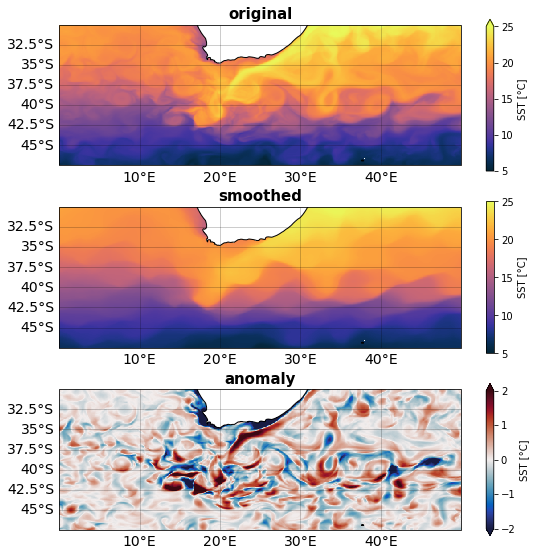

In [7]:
#### the original vs filtered vs anomalies were plotted
fig, axs= plt.subplots(nrows=3, ncols=1 , figsize=(9,9.5),subplot_kw={'projection': ccrs.PlateCarree()})


ds_agulhas.SST.plot(ax=axs[0], cmap=cmo.thermal, vmin=5, vmax=25, transform = ccrs.PlateCarree(),cbar_kwargs={'label': "SST [°C]"}, y='geolat_t', x='geolon_t')
ds_agulhas_smoothed.SST.plot(ax=axs[1], cmap=cmo.thermal,vmin=5, vmax=25, transform = ccrs.PlateCarree(),cbar_kwargs={'label': "SST [°C]"}, y='geolat_t', x='geolon_t')
ds_agulhas_ano.SST.plot(ax=axs[2], vmin=-2, vmax=2, cmap=cmo.balance, transform = ccrs.PlateCarree(),cbar_kwargs={'label': "SST [°C]"}, y='geolat_t', x='geolon_t')


for ax in axs:
    #ax.set_extent([0, 50, -47.5, -30])
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='black', alpha=0.2)
#axs.add_feature(ccrs.cartopy.feature.COASTLINE)
    gl.xlabels_top = False
    gl.ylabels_left = True
    gl.ylabels_right = False
    gl.xlabel_style = {'size': 14}
    gl.ylabel_style = {'size': 14}
    ax.coastlines()
axs[0].set_title('original', fontweight='bold', fontsize=15)
axs[1].set_title('smoothed', fontweight='bold', fontsize=15)
axs[2].set_title('anomaly', fontweight='bold', fontsize=15)
plt.savefig(pathp+'postprocessing_median.png', dpi=300, bbox_inches='tight')

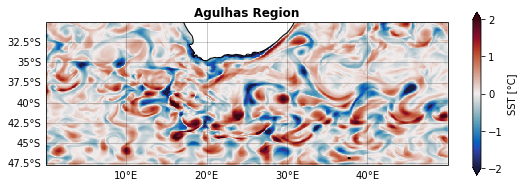

In [3]:
fig, axs= plt.subplots(nrows=1, ncols=1 , figsize=(9,3),subplot_kw={'projection': ccrs.PlateCarree()})
axs.set_extent([0, 50, -45, -30])

dsa.SST.isel(time=42).plot(ax=axs, vmin=-2, vmax=2, cmap=cmo.balance, transform = ccrs.PlateCarree(),cbar_kwargs={'label': "SST [°C]"})
gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='black', alpha=0.2)
#axs.add_feature(ccrs.cartopy.feature.COASTLINE)
gl.xlabels_top = False
gl.ylabels_left = True
gl.ylabels_right = False
axs.coastlines()
axs.set_title('Agulhas Region', fontweight='bold')
plt.savefig(pathp+'exemplary_median.png', dpi=300, bbox_inches='tight')

In [8]:
agday0=dsa.isel(time=0).sel(xt_ocean=slice(0,50), yt_ocean=slice(-45,-30))

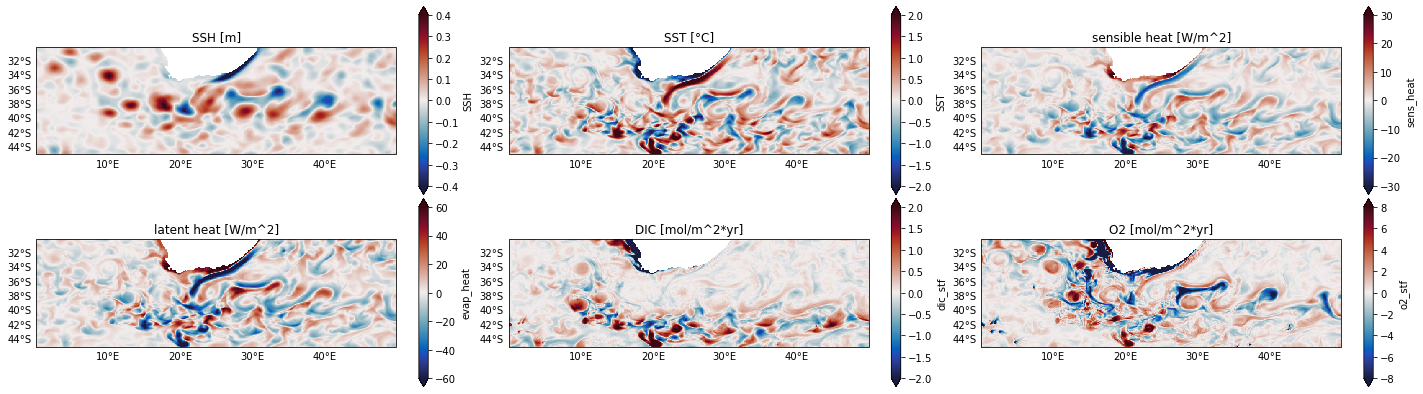

In [10]:
### snapshot of a certain time step for the Agulhas region for various variable anomalies
fig, axs= plt.subplots(nrows=2, ncols=3 , figsize=(25,7),subplot_kw={'projection': ccrs.PlateCarree()})
axs=axs.flatten()

agday0.SSH.plot(ax=axs[0], vmin=-0.4, vmax=0.4, cmap=cmo.balance, transform = ccrs.PlateCarree())
agday0.SST.plot(ax=axs[1], vmin=-2, vmax=2, cmap=cmo.balance, transform = ccrs.PlateCarree())
agday0.sens_heat.plot(ax=axs[2],vmin=-30, vmax=30, cmap=cmo.balance, transform = ccrs.PlateCarree())
agday0.evap_heat.plot(ax=axs[3],vmin=-60, vmax=60, cmap=cmo.balance, transform = ccrs.PlateCarree())
agday0.dic_stf.plot(ax=axs[4],vmin=-2, vmax=2, cmap=cmo.balance, transform = ccrs.PlateCarree())
agday0.o2_stf.plot(ax=axs[5],vmin=-8, vmax=8, cmap=cmo.balance, transform = ccrs.PlateCarree());

for i in range(6):
    gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='black', alpha=0)
    gl.xlabels_top = False
    gl.ylabels_right = False

axs[0].set_title('SSH [m]');
axs[1].set_title('SST [°C]');
axs[2].set_title('sensible heat [W/m^2]');
axs[3].set_title('latent heat [W/m^2]');
axs[4].set_title('DIC [mol/m^2*yr]');
axs[5].set_title('O2 [mol/m^2*yr]');
plt.subplots_adjust(hspace=0.02, wspace=0.05)
#plt.savefig('/gxfs_home/geomar/smomw577/plots/Boxcar/correlations/3x3_boxcar_agulhas_ano_month1.png', bbox_inches="tight", dpi=300)

In [13]:
ds_agulhas=ds_corr.sel(xt_ocean=slice(0,50), yt_ocean=slice(-45,-30))
#ds_agulhas_sst=ds_corr_sst.sel(xt_ocean=slice(0,50), yt_ocean=slice(-45,-30))

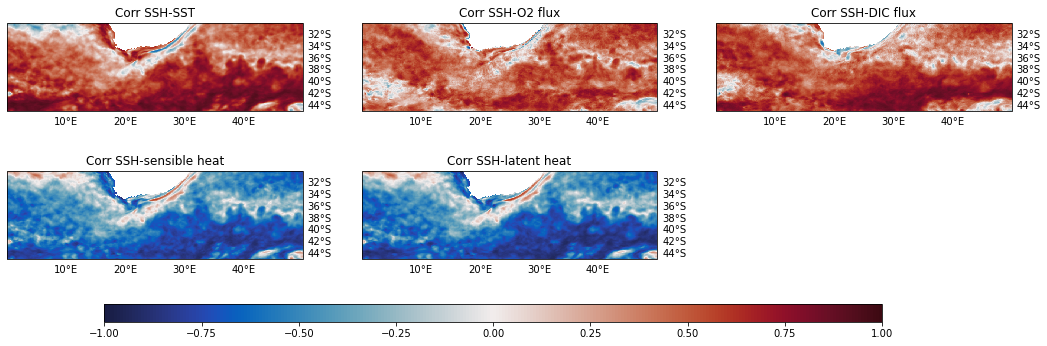

In [14]:
#correlations with sst and ssh in the Agulhas region
fig, axs= plt.subplots(nrows=2, ncols=3 , figsize=(18,5),subplot_kw={'projection': ccrs.PlateCarree()})
axs=axs.flatten()
im =ds_agulhas.corr_ssh_SST.plot(ax=axs[0], vmin=-1, vmax=1, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=False)
ds_agulhas.corr_ssh_sens_heat.plot(ax=axs[3], vmin=-1, vmax=1, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=False)
ds_agulhas.corr_ssh_evap_heat.plot(ax=axs[4], vmin=-1, vmax=1, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=False)
ds_agulhas.corr_ssh_o2_stf.plot(ax=axs[1], vmin=-1, vmax=1, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=False)
ds_agulhas.corr_ssh_dic_stf.plot(ax=axs[2], vmin=-1, vmax=1, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=False)
axs[5].set_axis_off()

for i in range(5):
    gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='black', alpha=0)
    gl.xlabels_top = False
    gl.ylabels_left = False

cbar_ax = fig.add_axes([0.2, 0.0, 0.6, 0.05])  # Left, bottom, width, height.
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')

axs[0].set_title('Corr SSH-SST');
axs[3].set_title('Corr SSH-sensible heat');
axs[4].set_title('Corr SSH-latent heat');
axs[1].set_title('Corr SSH-O2 flux');
axs[2].set_title('Corr SSH-DIC flux');

#plt.savefig('/gxfs_home/geomar/smomw577/plots/Boxcar/correlations/3x3_boxcar_agulhas_corr_monthly.png', bbox_inches="tight", dpi=300)

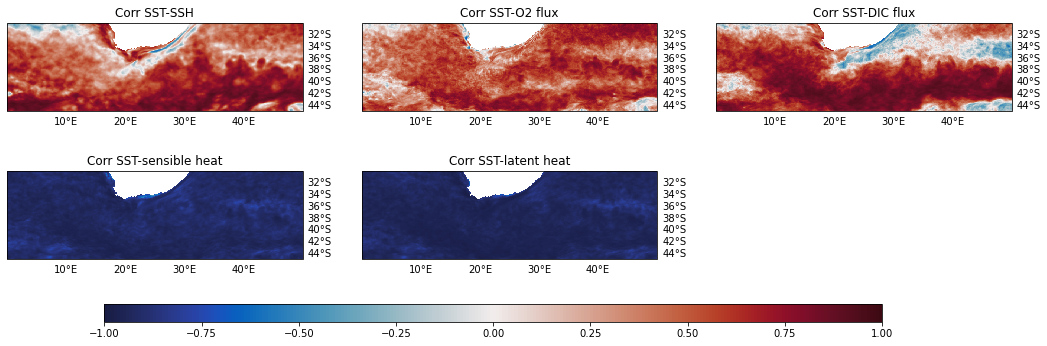

In [15]:
fig, axs= plt.subplots(nrows=2, ncols=3 , figsize=(18,5),subplot_kw={'projection': ccrs.PlateCarree()})
axs=axs.flatten()
im =ds_agulhas.corr_sst_SSH.plot(ax=axs[0], vmin=-1, vmax=1, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=False)
ds_agulhas.corr_sst_sens_heat.plot(ax=axs[3], vmin=-1, vmax=1, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=False)
ds_agulhas.corr_sst_evap_heat.plot(ax=axs[4], vmin=-1, vmax=1, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=False)
ds_agulhas.corr_sst_o2_stf.plot(ax=axs[1], vmin=-1, vmax=1, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=False)
ds_agulhas.corr_sst_dic_stf.plot(ax=axs[2], vmin=-1, vmax=1, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=False)
axs[5].set_axis_off()

for i in range(5):
    gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='black', alpha=0)
    gl.xlabels_top = False
    gl.ylabels_left = False

cbar_ax = fig.add_axes([0.2, 0.0, 0.6, 0.05])  # Left, bottom, width, height.
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')

axs[0].set_title('Corr SST-SSH');
axs[3].set_title('Corr SST-sensible heat');
axs[4].set_title('Corr SST-latent heat');
axs[1].set_title('Corr SST-O2 flux');
axs[2].set_title('Corr SST-DIC flux');

#plt.savefig('/gxfs_home/geomar/smomw577/plots/Boxcar/correlations/3x3_boxcar_agulhas_sst_corr_monthly.png', bbox_inches="tight", dpi=300)

# Smaller area

Next, we zoomed in even further.

In [16]:
time=42
agday0=dsa.isel(time=time).sel(xt_ocean=slice(15,30), yt_ocean=slice(-50,-35))
#mldday0=mld.isel(time=time).sel(xt_ocean=slice(15,30), yt_ocean=slice(-50,-35))
#jpday0=jpano.isel(time=time).sel(xt_ocean=slice(15,30), yt_ocean=slice(-50,-35))

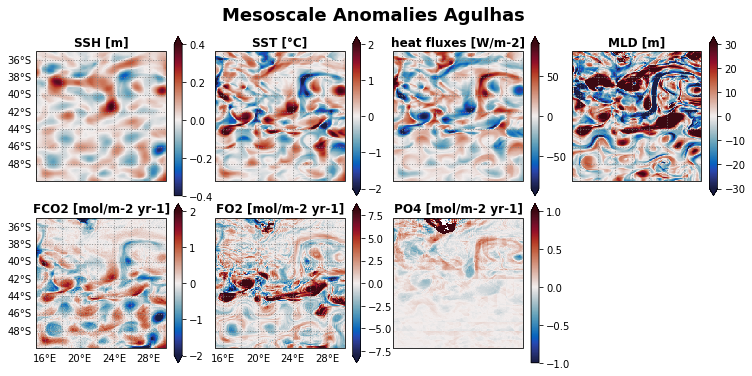

In [19]:
fig, axs= plt.subplots(nrows=2, ncols=4 , figsize=(12.5,6),subplot_kw={'projection': ccrs.PlateCarree()})
axs=axs.flatten()

agday0.SSH.plot(ax=axs[0], vmin=-.4, vmax=.4, cmap=cmo.balance, transform = ccrs.PlateCarree(),cbar_kwargs={'label': ""})
agday0.SST.plot(ax=axs[1], vmin=-2, vmax=2, cmap=cmo.balance, transform = ccrs.PlateCarree(),cbar_kwargs={'label': ""})
(agday0.sens_heat +agday0.evap_heat).plot(ax=axs[2],vmin=-90, vmax=90, cmap=cmo.balance, transform = ccrs.PlateCarree(),cbar_kwargs={'label': ""})
#.plot(ax=axs[2],vmin=-60, vmax=60, cmap=cmo.balance, transform = ccrs.PlateCarree(),cbar_kwargs={'label': ""})
agday0.mld.plot(ax=axs[3],vmin=-30, vmax=30, cmap=cmo.balance, transform = ccrs.PlateCarree(),cbar_kwargs={'label': ""})
agday0.dic_stf.plot(ax=axs[4],vmin=-2, vmax=2, cmap=cmo.balance, transform = ccrs.PlateCarree(),cbar_kwargs={'label': ""})
agday0.o2_stf.plot(ax=axs[5],vmin=-8, vmax=8, cmap=cmo.balance, transform = ccrs.PlateCarree(),cbar_kwargs={'label': ""});
(agday0.jp_all*60*60*24*365).plot(ax=axs[6],vmin=-1, vmax=1, cmap=cmo.balance, transform = ccrs.PlateCarree(),cbar_kwargs={'label': ""});


for i in range(6):
    gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.8, linestyle='dotted')
    gl.xlabels_top = False
    gl.ylabels_right = False
    if i in [1,2,3,5,6,7]:
        gl.ylabels_left = False
    if i in [0,1,2,3]:
        gl.xlabels_bottom = False
axs[7].set_axis_off()

axs[0].set_title('SSH [m]', fontweight='bold');
axs[1].set_title('SST [°C]', fontweight='bold');
axs[2].set_title('heat fluxes [W/m-2]', fontweight='bold');
axs[3].set_title('MLD [m]', fontweight='bold');
axs[4].set_title('FCO2 [mol/m-2 yr-1]', fontweight='bold');
axs[5].set_title('FO2 [mol/m-2 yr-1]', fontweight='bold');
axs[6].set_title('PO4 [mol/m-2 yr-1]', fontweight='bold');
plt.subplots_adjust(hspace=0.05, wspace=0.1)
plt.suptitle('Mesoscale Anomalies Agulhas', fontweight='bold', fontsize=18, y=.95);
plt.savefig('/gxfs_home/geomar/smomw577/plots/Boxcar/0181-0190/3x3_boxcar_agulhas_ano_panels_median.png', bbox_inches="tight", dpi=300)

In [18]:
reg=dsa.sel(xt_ocean=slice(15,30), yt_ocean=slice(-50,-35))
hf_SST=xr.corr((reg.sens_heat +reg.evap_heat), reg.SST, dim='time')
CO2_O2=xr.corr(reg.dic_stf, reg.o2_stf, dim='time')
hf_CO2=xr.corr((reg.sens_heat +reg.evap_heat), reg.dic_stf, dim='time')
hf_O2=xr.corr((reg.sens_heat +reg.evap_heat), reg.o2_stf, dim='time')

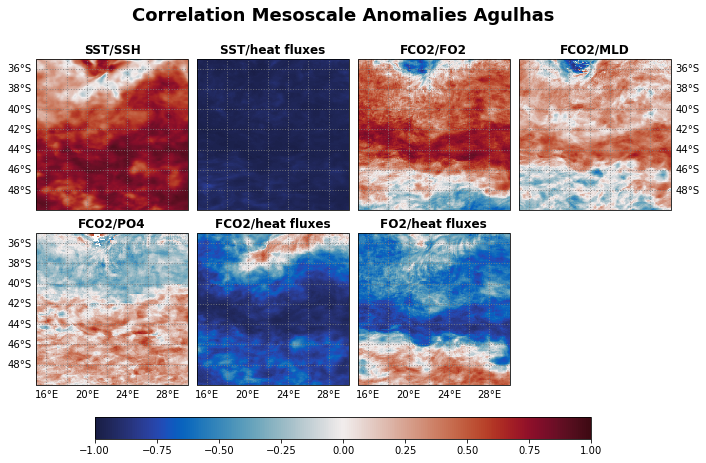

In [28]:
agcorr=ds_corr.sel(xt_ocean=slice(15,30), yt_ocean=slice(-50,-35))
mldcorr=mld_corr.sel(xt_ocean=slice(15,30), yt_ocean=slice(-50,-35))
jpcorr=jpcorr_all.sel(xt_ocean=slice(15,30), yt_ocean=slice(-50,-35))
fig, axs= plt.subplots(nrows=2, ncols=4 , figsize=(11.5,6),subplot_kw={'projection': ccrs.PlateCarree()})
axs=axs.flatten()

agcorr.corr_sst_SSH.plot(ax=axs[0], vmin=-1, vmax=1, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=False)
hf_SST.plot(ax=axs[1], vmin=-1, vmax=1, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=False)
CO2_O2.plot(ax=axs[2], vmin=-1, vmax=1, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=False)
mldcorr.corr_mld_dic_stf_ctrl.plot(ax=axs[3], vmin=-1, vmax=1, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=False)
jpcorr.corr_jp_dic_stf_ctrl.plot(ax=axs[4], vmin=-1, vmax=1, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=False)
hf_CO2.plot(ax=axs[5], vmin=-1, vmax=1, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=False)
hf_O2.plot(ax=axs[6], vmin=-1, vmax=1, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=False)

#agcorr.corr_sst_o2_stf.plot(ax=axs[4], vmin=-1, vmax=1, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=False)
#agcorr.corr_sst_dic_stf.plot(ax=axs[5], vmin=-1, vmax=1, cmap=cmo.balance, transform = ccrs.PlateCarree(), add_colorbar=False)

for i in range(7):
    gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.8, linestyle='dotted')
    gl.xlabels_top = False
    gl.ylabels_right = False
    if i in [3,7]:
        gl.ylabels_right = True
    if i in [1,2,3,5,6,7]:
        gl.ylabels_left = False
    if i in [0,1,2,3]:
        gl.xlabels_bottom = False
axs[7].set_axis_off()

cbar_ax = fig.add_axes([0.2, 0.0, 0.6, 0.05])  # Left, bottom, width, height.
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')

axs[0].set_title('SST/SSH', fontweight='bold');
axs[1].set_title('SST/heat fluxes', fontweight='bold');
axs[2].set_title('FCO2/FO2', fontweight='bold');
axs[3].set_title('FCO2/MLD', fontweight='bold');
axs[4].set_title('FCO2/PO4', fontweight='bold');
axs[5].set_title('FCO2/heat fluxes', fontweight='bold');
axs[6].set_title('FO2/heat fluxes', fontweight='bold');
plt.subplots_adjust(hspace=0.15, wspace=0.01)
plt.suptitle('Correlation Mesoscale Anomalies Agulhas', fontweight='bold', fontsize=18, y=1);

plt.savefig('/gxfs_home/geomar/smomw577/plots/Boxcar/0181-0190/3x3_boxcar_agulhas_corr_panels_median.png', bbox_inches="tight", dpi=300)

In [27]:
jpcorr

<xarray.Dataset>
Dimensions:                   (yt_ocean: 205, xt_ocean: 150)
Coordinates:
    geolon_t                  (yt_ocean, xt_ocean) float64 15.05 15.15 ... 29.95
    geolat_t                  (yt_ocean, xt_ocean) float64 -49.96 ... -35.04
  * xt_ocean                  (xt_ocean) float64 15.05 15.15 ... 29.85 29.95
  * yt_ocean                  (yt_ocean) float64 -49.96 -49.9 ... -35.12 -35.04
    st_ocean                  float64 ...
Data variables:
    corr_jp_dic_stf_ctrl      (yt_ocean, xt_ocean) float64 dask.array<chunksize=(205, 150), meta=np.ndarray>
    corr_jp_o2_stf_ctrl       (yt_ocean, xt_ocean) float64 dask.array<chunksize=(205, 150), meta=np.ndarray>
    corr_jp_dic_stf_1PctTo2X  (yt_ocean, xt_ocean) float64 dask.array<chunksize=(205, 150), meta=np.ndarray>
    corr_jp_o2_stf_1PctTo2X   (yt_ocean, xt_ocean) float64 dask.array<chunksize=(205, 150), meta=np.ndarray>